### Visualization Performance


In [1]:
import numpy as np
from envs import TradingEnv
from agent import DQNAgent
import pandas as pd
from datetime import datetime
import itertools
from matplotlib import pyplot as plt
import matplotlib.dates as mdate
import matplotlib.dates as mdates
from utils import get_data, maybe_make_dir, plot_all,buy_and_hold_benchmark 
import glob
import os

In [2]:
# get last weight
newest = True

test_weight = {
    'transformer':'dataset_2015_2020_transformer-202208242215-ep12',
    'conv1d':'dataset_2015_2020_conv1d-202208251231-ep40',
    'dnn':'dataset_2015_2020_dnn-202208210044-ep12',
    'lstm':'dataset_2015_2020_lstm-202208201118-ep12',
}

# test data
stock = 'dataset'
stock_name = stock+'_2021_2021'
stock_table = f"{stock_name.split('_')[0]}_table"
initial_invest = 1000000

if newest:
    for model in test_weight.keys():
        target_weight_list = [x.replace('.h5','') for x in glob.glob(os.path.join('weights',model,'*.h5')) if stock in x]
        test_weight[model] = target_weight_list[-1].split('\\')[2]

# window length
# slide = 30
from config import slide

data = get_data(stock_name, stock_table)
model_metric = {}
test_weight

{'transformer': 'dataset_2015_2020_transformer-202208302355-ep40',
 'conv1d': 'dataset_2015_2020_conv1d-202208310944-ep40',
 'dnn': 'dataset_2015_2020_dnn-202208310709-ep40',
 'lstm': 'dataset_2015_2020_lstm-202208311227-ep40'}

In [3]:
%%time


for model, weight in test_weight.items():
    # env = TradingEnv(train_data, args.initial_invest)
    env = TradingEnv(data, model, initial_invest, slide)
    # fix
    action_combo = list(map(list, itertools.product([0, 1, 2], repeat=env.n_stock)))
    action_size = env.action_space.n
    state_size = np.array(env.reset()).shape
    agent = DQNAgent(state_size, action_size, 'test', model)
    # scaler = get_scaler(env)

    portfolio_value = []

    # remake the env with test data
    env = TradingEnv(data, model, initial_invest, slide)
    # load trained weights
    agent.load(f'weights/{model}/{weight}.h5')
    daily_portfolio_value = []

    state = env.reset()
    action_list=[]
    for time in range(env.n_step):
        action = agent.act(state)
        # fix
        action_vec = action_combo[action]
        action_list.append(action)
        next_state, reward, done, info = env.step(action)
        print(model, action, action_vec, round(reward,0), info, env.cash_in_hand, env.stock_owned)
        # next_state = scaler.transform([next_state])
        daily_portfolio_value.append(info['cur_val'])
        state = next_state
        if done:
            # plot_all(stock_name, model, daily_portfolio_value, env)
            # print(len(action_list),action_list)    
            portfolio_value.append(info['cur_val']) # append episode end portfolio value
            break
    print(set(action_list),'\n',action_list)    
    model_metric[model] = daily_portfolio_value


1/1 [==============================] - 5s 5s/step
transformer 213 [2, 1, 2, 2, 0] 0.0 {'cur_val': 1000000.0} 930871.117401123 [200, 0, 200, 200, 0]
1/1 [==============================] - 0s 26ms/step
transformer 213 [2, 1, 2, 2, 0] 3725.0 {'cur_val': 1003724.5380401611} 858017.696762085 [400, 0, 400, 400, 0]
1/1 [==============================] - 0s 28ms/step
transformer 213 [2, 1, 2, 2, 0] -1747.0 {'cur_val': 1001977.8469085693} 786037.6216888428 [600, 0, 600, 600, 0]
1/1 [==============================] - 0s 29ms/step
transformer 213 [2, 1, 2, 2, 0] 3770.0 {'cur_val': 1005748.0228424072} 712800.8213043213 [800, 0, 800, 800, 0]
1/1 [==============================] - 0s 27ms/step
transformer 213 [2, 1, 2, 2, 0] 2424.0 {'cur_val': 1008171.8173980713} 638958.0722808838 [1000, 0, 1000, 1000, 0]
1/1 [==============================] - 0s 28ms/step
transformer 213 [2, 1, 2, 2, 0] -3455.0 {'cur_val': 1004716.6706085205} 565806.3526153564 [1200, 0, 1200, 1200, 0]
1/1 [=========================

dataset_2021_2021 data


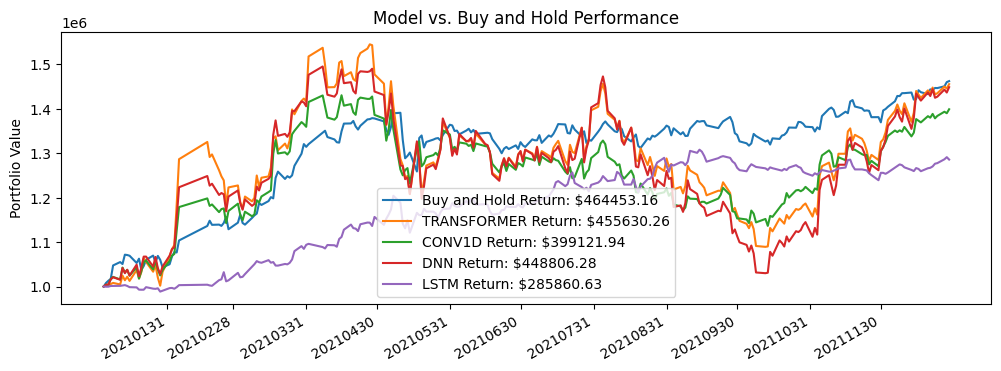

In [4]:

def plot_all_model(stock_name, model_metric, env):
    print(stock_name,'data')
    """combined plots of plot_portfolio_transaction_history and plot_portfolio_performance_comparison"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())

    dates, buy_and_hold_portfolio_values, buy_and_hold_return = buy_and_hold_benchmark(stock_name, env.init_invest, env.n_stock)
    ax.set_title(f'Model vs. Buy and Hold Performance')
    dates = [datetime.strptime(d, '%Y%m%d').date() for d in dates]
    ###
    dates = dates[:-1]
    buy_and_hold_portfolio_values = buy_and_hold_portfolio_values[:-1]
    # print(f'dates:     {len(dates)} \ndaily value:{len(daily_portfolio_value)}\nBH value:{len(buy_and_hold_portfolio_values)}')
    ax.plot(dates, buy_and_hold_portfolio_values, label=f'Buy and Hold Return: ${buy_and_hold_return:.2f}')
    ###
    for model, portfolio in model_metric.items():
        agent_return = portfolio[-1] - env.init_invest
        ax.plot(dates, portfolio, label=f'{model.upper()} Return: ${agent_return:.2f}')
    ax.set_ylabel('Portfolio Value')
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y%m%d'))
    # plt.xticks(pd.date_range('2018-1-02', '2019-08-22', freq='1m'))
    plt.xticks(pd.date_range(dates[0],dates[-1],freq='1m'))
    ax.legend()
    plt.gcf().autofmt_xdate()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

plot_all_model(stock_name, model_metric, env)    

In [5]:
# agent.save('test_with.h5')
# agent.save('test_without.h5')